In [36]:
import torch
from torch import nn
import torch.nn.functional as F
from PIL import Image
import torchvision.transforms as transforms


# credit to : https://github.com/ziwei-jiang/AdaIN-Style-Transfer-PyTorch/tree/master

class AdaIN(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x, y):
        eps = 1e-5
        mean_x = torch.mean(x, dim=[2, 3])
        mean_y = torch.mean(y, dim=[2, 3])

        std_x = torch.std(x, dim=[2, 3])
        std_y = torch.std(y, dim=[2, 3])

        mean_x = mean_x.unsqueeze(-1).unsqueeze(-1)
        mean_y = mean_y.unsqueeze(-1).unsqueeze(-1)

        std_x = std_x.unsqueeze(-1).unsqueeze(-1) + eps
        std_y = std_y.unsqueeze(-1).unsqueeze(-1) + eps

        out = (x - mean_x) / std_x * std_y + mean_y

        return out


In [31]:
class StyleTransferNet(nn.Module):
    def __init__(self, encoder_sd_path="saved_models/encoder_state_dict.pt", decoder_sd_path=None):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(3, 3, kernel_size=(1, 1), stride=(1, 1)),
            nn.Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode='reflect'),
            nn.ReLU(inplace=True),

            nn.Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode='reflect'),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),

            nn.Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode='reflect'),
            nn.ReLU(inplace=True),

            nn.Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode='reflect'),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),

            nn.Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode='reflect'),
            nn.ReLU(inplace=True),

            nn.Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode='reflect'),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode='reflect'),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode='reflect'),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),

            nn.Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode='reflect'),
            nn.ReLU(inplace=True)
        )
        
        if encoder_sd_path is not None:
            self.encoder.load_state_dict(torch.load(encoder_sd_path))
        for parameter in self.encoder.parameters():
            parameter.requires_grad = False

        self.decoder = nn.Sequential(
            nn.Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode='reflect'),
            nn.ReLU(inplace=True),

            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode='reflect'),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode='reflect'),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode='reflect'),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode='reflect'),
            nn.ReLU(inplace=True),

            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode='reflect'),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode='reflect'),
            nn.ReLU(inplace=True),

            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode='reflect'),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode='reflect'),

        )
        
        if decoder_sd_path is not None:
            self.decoder.load_state_dict(torch.load(decoder_sd_path))
        
        self.adaIN = AdaIN()
        self.mse_criterion = nn.MSELoss()

    def forward(self, x, alpha=1.0):

        content_img = x[0]
        style_img = x[1]

        encode_content = self.encoder(content_img)
        encode_style = self.encoder(style_img)

        encode_out = self.adaIN(encode_content, encode_style)

        if self.training:
            gen_img = self.decoder(encode_out)
            encode_gen = self.encoder(gen_img)

            fm11_style = self.encoder[:3](style_img)
            fm11_gen = self.encoder[:3](gen_img)

            fm21_style = self.encoder[3:8](fm11_style)
            fm21_gen = self.encoder[3:8](fm11_gen)

            fm31_style = self.encoder[8:13](fm21_style)
            fm31_gen = self.encoder[8:13](fm21_gen)

            loss_content = self.mse_criterion(encode_gen, encode_out)

            loss_style = self.mse_criterion(torch.mean(fm11_gen, dim=[2, 3]), torch.mean(fm11_style, dim=[2, 3])) + \
                         self.mse_criterion(torch.mean(fm21_gen, dim=[2, 3]), torch.mean(fm21_style, dim=[2, 3])) + \
                         self.mse_criterion(torch.mean(fm31_gen, dim=[2, 3]), torch.mean(fm31_style, dim=[2, 3])) + \
                         self.mse_criterion(torch.mean(encode_gen, dim=[2, 3]), torch.mean(encode_style, dim=[2, 3])) + \
                         self.mse_criterion(torch.std(fm11_gen, dim=[2, 3]), torch.std(fm11_style, dim=[2, 3])) + \
                         self.mse_criterion(torch.std(fm21_gen, dim=[2, 3]), torch.std(fm21_style, dim=[2, 3])) + \
                         self.mse_criterion(torch.std(fm31_gen, dim=[2, 3]), torch.std(fm31_style, dim=[2, 3])) + \
                         self.mse_criterion(torch.std(encode_gen, dim=[2, 3]), torch.std(encode_style, dim=[2, 3]))

            return loss_content, loss_style
        encode_out = alpha * encode_out + (1 - alpha) * encode_content
        gen_img = self.decoder(encode_out)
        return gen_img

In [33]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [35]:
model = StyleTransferNet(decoder_sd_path="saved_models/decoder.pth")
model.to(device);

In [106]:
input_image = Image.open("content/Tuebingen_Neckarfront.jpg")
style_image = Image.open("style/vangogh_starry_night.jpg")

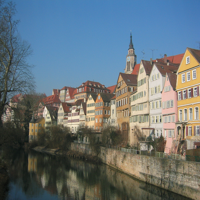

In [107]:
input_image.resize((200, 200))

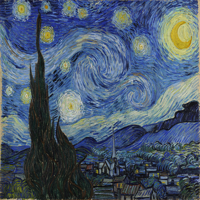

In [108]:
style_image.resize((200, 200))

In [109]:
with torch.no_grad():
    model.eval()
    input_image = transforms.Resize(512)(input_image)
    style_image = transforms.Resize(512)(style_image)

    input_tensor = transforms.ToTensor()(input_image).unsqueeze(0).to(device)
    style_tensor = transforms.ToTensor()(style_image).unsqueeze(0).to(device)
    if input_tensor.shape[1] == 1:
        input_tensor = input_tensor.repeat((1, 3, 1, 1))
    
    out_tensor = model([input_tensor, style_tensor], alpha = 1.0)

In [110]:
import numpy as np

In [111]:
out_tensor.min(), out_tensor.max()

(tensor(-0.1759, device='cuda:0'), tensor(1.3132, device='cuda:0'))

In [112]:
def show_tensor(tensor_image):
    tmp = tensor_image[0].cpu().permute(1, 2, 0)
    plt.imshow((tmp - tmp.min())/(tmp.max() - tmp.min()))

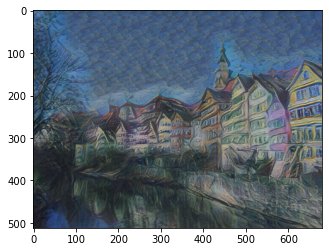

In [113]:
show_tensor(out_tensor)